In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [6]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    
    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-9) + (1 - x) * tf.math.log(1 - x_decoded + 1e-9), 1)

    KL_term = tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1) / 2


    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return  tf.exp(1/2 * z_log_var) * epsilon + z_mean

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [8]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 10)           2570        ['dense_1[0][0]']                
                                                                                            

In [9]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270,096
Trainable params: 270,096
Non-trainable params: 0
_________________________________________________________________


## e)

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 5s 8ms/step - loss: 226.2950
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 138.9398
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 126.4629
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 120.2052
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 116.5470
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 114.4795
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 112.4427
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 111.1741
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 110.1279
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 108.8586


## f)

In [15]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)[-1]
z_test_pred

313/313 [==============================] - 0s 1ms/step


array([[-0.5014428 ,  0.35884848,  1.296329  , ..., -0.1518459 ,
        -2.488448  , -0.33851868],
       [ 0.37729388,  1.1310608 ,  0.49515015, ...,  0.5085364 ,
         2.0744798 , -1.6180874 ],
       [ 2.5945725 ,  1.5390009 , -0.94604206, ..., -0.20876996,
         0.04578107, -0.64614975],
       ...,
       [ 0.33796546, -0.40268293, -1.4096107 , ..., -0.7760951 ,
         0.05619687,  1.1043854 ],
       [-0.03172714,  1.0297432 ,  1.5016307 , ..., -0.32891098,
         0.71082973,  1.0212153 ],
       [-0.8554137 ,  0.06905232, -1.7278568 , ...,  0.7669064 ,
         1.2214175 ,  0.8397147 ]], dtype=float32)

In [16]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae.decoder.predict(z_test_pred)

313/313 [==============================] - 0s 933us/step


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

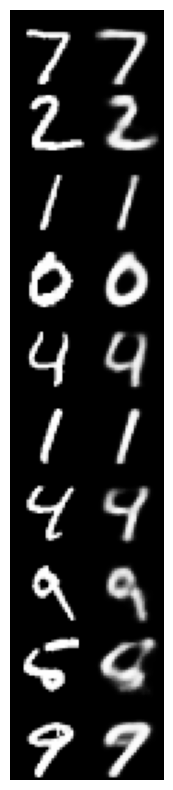

In [18]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [19]:
# use z_test_pred

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=2)

In [23]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred)

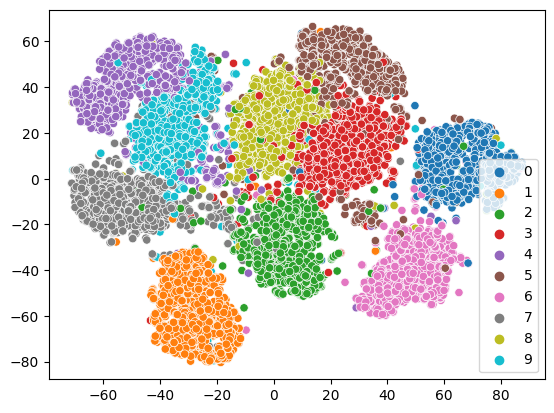

In [24]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

### h)

In [28]:

prior = np.random.normal(0,1,(10,10))
likelihood = vae.decoder.predict(prior)

1/1 [==============================] - 0s 54ms/step


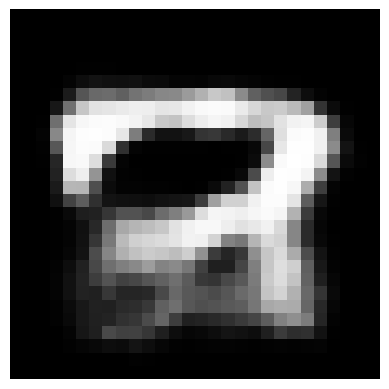

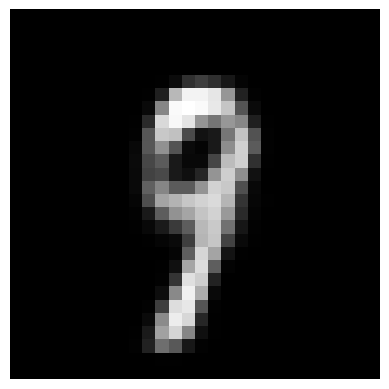

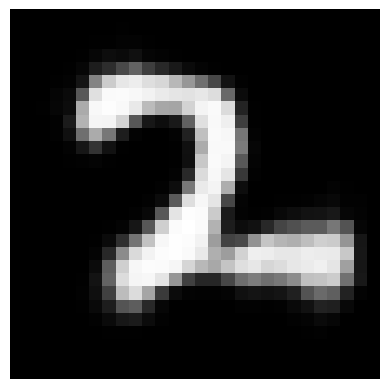

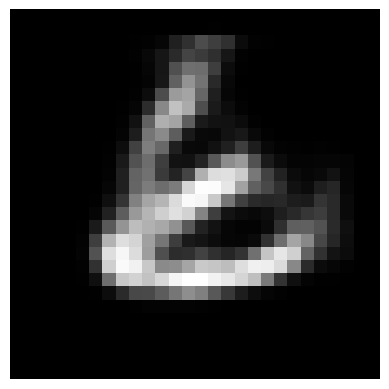

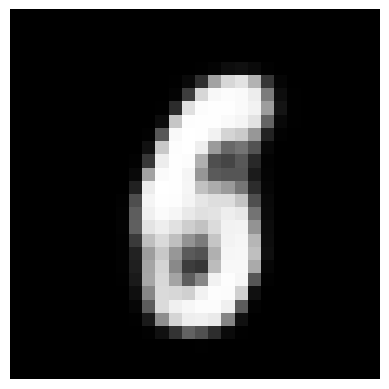

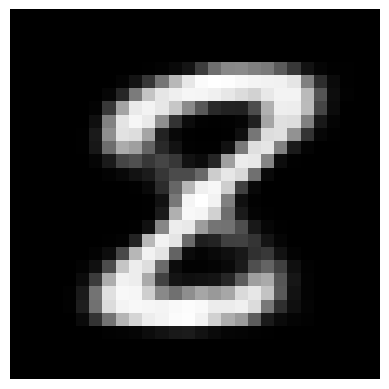

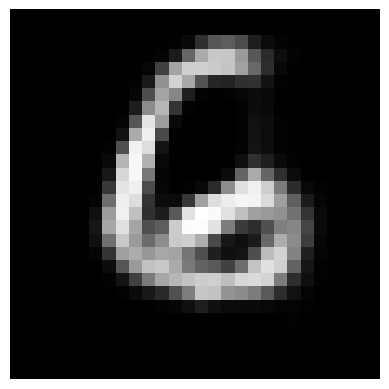

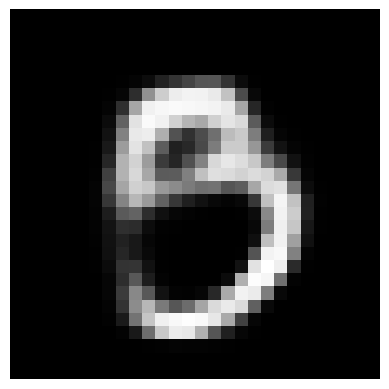

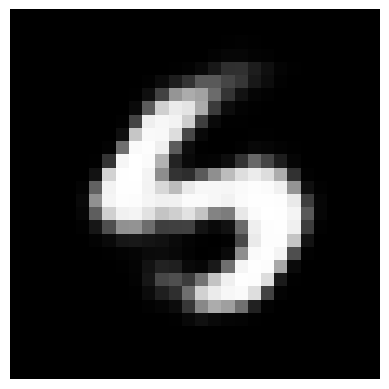

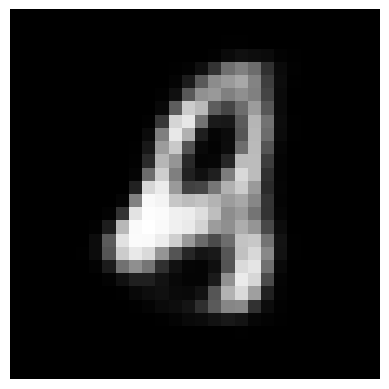

In [33]:
for i in range(10):
    
    plt.imshow(likelihood[i, :].reshape(digit_size, digit_size), cmap='Greys_r')
    plt.axis('off')
    plt.show()

In [32]:
# Task 2

In [35]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim + 1))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder_c = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_c.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 785)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 256)          201216      ['input_4[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 256)          65792       ['dense_7[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 10)           2570        ['dense_8[0][0]']                
                                                                                            

In [36]:
latent_inputs = keras.Input(shape=(latent_dim + 1,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder_c = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder_c.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_9 (Dense)             (None, 256)               3072      
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 784)               201488    
                                                                 
Total params: 270,352
Trainable params: 270,352
Non-trainable params: 0
_________________________________________________________________


In [37]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            
            
            label = data[:, -1]
            label = tf.reshape(label, [-1, 1])
            
            reconstruction = self.decoder(tf.concat([z, label], axis=1))
            
            total_loss = -elbo_vae(data[:, :-1], reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [38]:
vae_c = cVAE(encoder_c, decoder_c)

vae_c.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.005))

x_train_c = tf.concat([x_train, 
                       tf.cast(y_train.reshape(-1, 1), float)],
                       axis = 1)
                     
vae_c.fit(x_train_c, epochs=48, batch_size=512)

Epoch 1/48
118/118 [==============================] - 4s 23ms/step - loss: 230.5704
Epoch 2/48
118/118 [==============================] - 3s 22ms/step - loss: 146.0122
Epoch 3/48
118/118 [==============================] - 3s 22ms/step - loss: 131.3284
Epoch 4/48
118/118 [==============================] - 2s 21ms/step - loss: 125.9791
Epoch 5/48
118/118 [==============================] - 2s 21ms/step - loss: 123.0442
Epoch 6/48
118/118 [==============================] - 3s 22ms/step - loss: 121.1712
Epoch 7/48
118/118 [==============================] - 3s 21ms/step - loss: 119.8036
Epoch 8/48
118/118 [==============================] - 3s 22ms/step - loss: 118.3277
Epoch 9/48
118/118 [==============================] - 2s 21ms/step - loss: 116.4315
Epoch 10/48
118/118 [==============================] - 3s 22ms/step - loss: 115.3289
Epoch 11/48
118/118 [==============================] - 3s 21ms/step - loss: 114.5759
Epoch 12/48
118/118 [==============================] - 3s 22ms/step - loss

In [40]:
# representation in the latent space of observations from test ds
z_test_pred = vae_c.encoder.predict(tf.concat([x_test,tf.cast(y_test.reshape(-1, 1), float)],axis = 1))[-1]
z_test_pred

313/313 [==============================] - 0s 1ms/step


array([[ 0.21650562,  0.57975686,  0.6623877 , ...,  2.59779   ,
         0.7754694 , -1.2474891 ],
       [-1.8669583 , -0.3223991 ,  0.48501492, ..., -0.46248433,
         0.98378646,  0.25220138],
       [ 1.5116409 ,  0.8305876 ,  0.24846455, ...,  0.38236505,
        -0.06932138, -1.6534001 ],
       ...,
       [ 0.8867663 ,  0.9116635 , -0.3837997 , ...,  1.061614  ,
        -1.6225451 , -0.67984056],
       [ 1.04969   , -0.614159  , -0.01572513, ..., -0.14146341,
         2.4710639 ,  0.19151065],
       [-0.73250496,  0.74795365, -1.5157706 , ..., -1.6958604 ,
        -0.08231466,  1.8158591 ]], dtype=float32)

In [42]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae_c.decoder.predict(tf.concat([z_test_pred,tf.cast(y_test.reshape(-1, 1), float)],axis = 1))

313/313 [==============================] - 0s 1ms/step


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

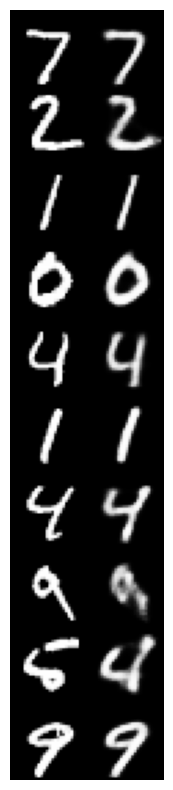

In [44]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [45]:
# use z_test_pred

In [46]:
from sklearn.manifold import TSNE

In [47]:
tsne = TSNE(n_components=2)

In [48]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred)

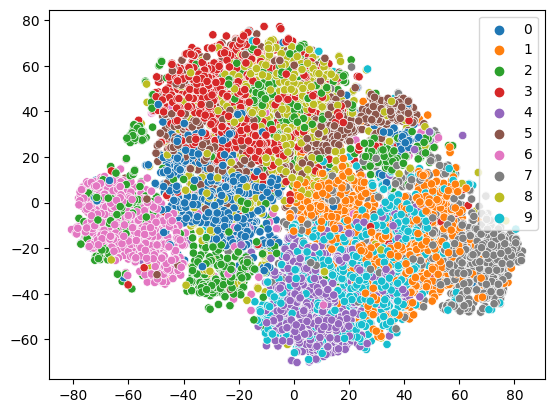

In [49]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

### h)

array([[-0.480572  ,  0.51147724, -0.95291507, -1.0678231 ,  0.1330772 ,
         0.00648721,  0.65971587,  0.13214068,  0.36220675, -0.27867418],
       [ 0.12853378, -0.04046938,  1.15962641, -0.50844024,  0.30705878,
        -1.87413727, -0.02058308, -0.7920691 ,  0.97582967, -1.43877345],
       [-1.4144249 , -0.98187989,  0.345397  ,  0.85136129,  1.13322552,
        -0.76750497, -0.35540408,  0.09538368,  0.51866324, -0.19667031],
       [-0.91204361,  0.44349593,  0.63898921,  1.2340242 ,  0.10390496,
         0.77244951,  0.13447743, -0.57661859, -0.52199034, -0.91224174],
       [ 0.21393524, -0.04321065, -0.08951108, -1.10207527, -0.98373101,
        -0.89339085, -0.76703964, -0.54684164, -0.98092189, -0.27638642],
       [-0.79069866,  0.55012893, -0.28940899, -1.55171988,  0.8188402 ,
        -0.77593448, -0.46344731,  0.03430823, -0.65647024, -1.20296654],
       [ 1.53721719, -1.69967177, -0.36801884, -0.67245091, -0.7138186 ,
         0.05693416, -1.17241413,  0.53978607

In [54]:

prior = np.concatenate([np.random.normal(0,1,(10,10)), [[1] for _ in range(10)]], axis = 1)
likelihood = vae_c.decoder.predict(prior)

1/1 [==============================] - 0s 50ms/step


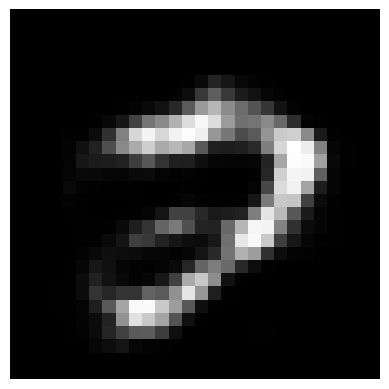

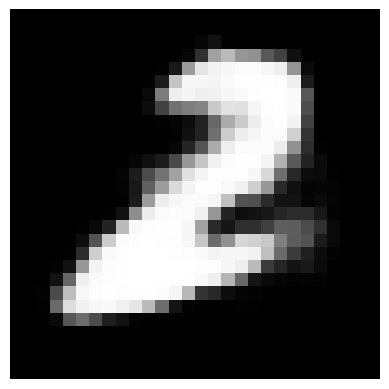

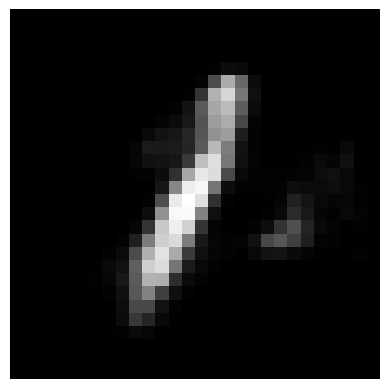

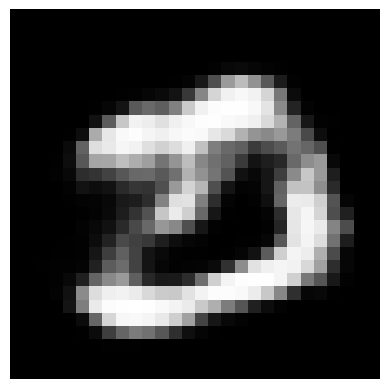

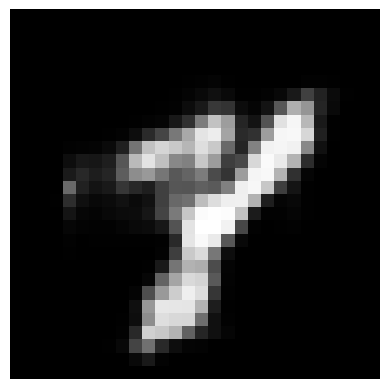

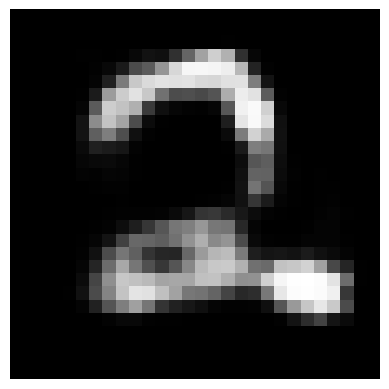

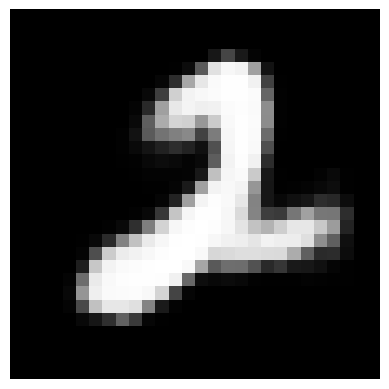

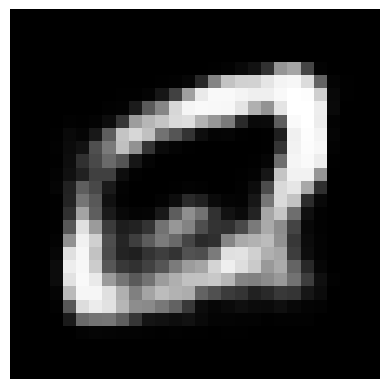

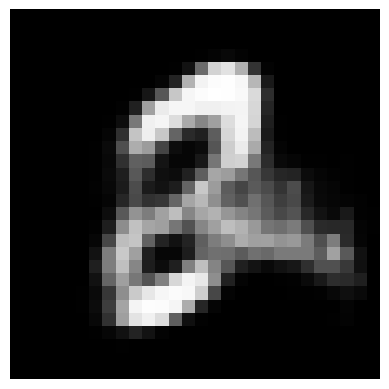

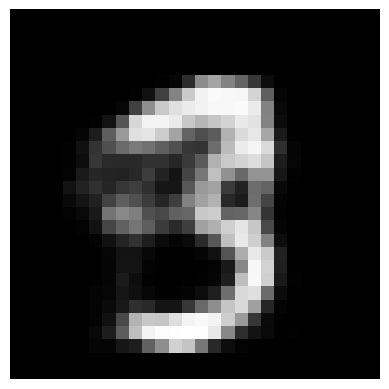

In [55]:
for i in range(10):
    
    plt.imshow(likelihood[i, :].reshape(digit_size, digit_size), cmap='Greys_r')
    plt.axis('off')
    plt.show()